# take2

**GOAL**: Keep It Stupid Simple = KISS.

**Dependencies:**
 - [pocketknives](https://github.com/zjwilliams20/pocketknives)

**References:**
 1. [ilqgames/python](https://github.com/HJReachability/ilqgames/blob/master/python)

In [1]:
from time import perf_counter as pc

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import torch

from decentralized import split_agents
import decentralized as dec
import pocketknives

π = np.pi

In [2]:
%load_ext autoreload
%autoreload 1
%aimport decentralized.control, decentralized.dynamics, decentralized.cost, decentralized.problem, decentralized.util

In [3]:
%matplotlib widget
plt.rcParams['axes.grid'] = True

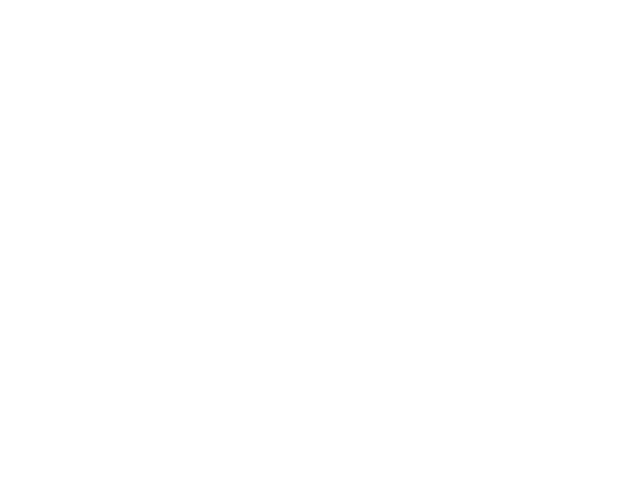

In [5]:
# fig = plt.figure(figsize=(3.7, 3.7))
fig = plt.figure()

In [16]:
def pos_mask(x_dims):
    """Return a mask that's true wherever there's an x or y position""" 
    return np.array([i % x_dims[0] < 2 for i in range(sum(x_dims))])

In [17]:
def plot_solve(X, J, x_goal, x_dims=None):
    """Plot the resultant trajectory on plt.gcf()"""

    if not x_dims:
        x_dims = [X.shape[1]]
        
    N = X.shape[0]
    t = np.arange(N) * dt
    
    X_split = split_agents(X, x_dims)
    x_goal_split = split_agents(x_goal.reshape(1,-1), x_dims)
    
    for Xi, xg in zip(X_split, x_goal_split):
        plt.scatter(Xi[:,0], Xi[:,1], c=t)
        plt.scatter(Xi[0,0], Xi[0,1], 80, 'g', 'x', label="$x_0$")
        plt.scatter(xg[0,0], xg[0,1], 80, 'r', 'x', label="$x_f$")
    
    plt.margins(0.1)
    plt.title(f"Final Cost: {J:.3g}")
    plt.draw()

## single-agent problem

In [8]:
# Symbolic dynamics example.
x = np.array([0, 0, 1, 0])
u = np.array([0, 1])
dynamics = dec.UnicycleDynamics4dSymbolic(1.0)
dynamics(x, u)

array([1., 0., 1., 1.])

In [19]:
dt = 0.1
N = 50

x = np.array([-10, 10, 0, 0], dtype=float)
x_goal = np.zeros((4, 1), dtype=float).T

dynamics = dec.UnicycleDynamics4dSymbolic(dt)

Q = np.diag(torch.tensor([1., 1, 0, 0]))
Qf = 1000 * np.eye(Q.shape[0])
R = np.eye(2)
cost = dec.ReferenceCost(x_goal, Q, R, Qf)

prob = dec.ilqrProblem(dynamics, cost)
ilqr = dec.ilqrSolver(prob, N)
X, U, J = ilqr.solve(x)

plt.clf()
plot_solve(X, J, x_goal)

0/50	J: 210000
1/50	J: 106521	μ: 0.5	Δ: 0.5
2/50	J: 7777.6	μ: 0.125	Δ: 0.25
3/50	J: 4623.43	μ: 0.015625	Δ: 0.125
4/50	J: 3518.18	μ: 0.000976562	Δ: 0.0625
5/50	J: 3249.36	μ: 3.05176e-05	Δ: 0.03125
6/50	J: 3187.49	μ: 0	Δ: 0.015625
7/50	J: 3124.95	μ: 0	Δ: 0.0078125
8/50	J: 3094.62	μ: 0	Δ: 0.00390625
9/50	J: 3081.12	μ: 0	Δ: 0.00195312
10/50	J: 3074.96	μ: 0	Δ: 0.000976562


## multi-agent problem

### initializing the scene
Here, we define some initial positions within some distance of each other, and then rotate them about the origin by some random angle to hopefully create some interesting scenarios.

In [22]:
def paper_setup():
    """Hardcoded example with reasonable consistency eyeballed from 
       Potential-iLQR paper
    """
    x0 = torch.tensor([[0.5, 1.5, 0, 0.1,
                        2.5, 1.5, 0, π,
                        1.5, 1.3, 0, π/2]], 
                     dtype=torch.float).T
    x_goal = torch.tensor([[2.5, 1.5, 0, 0, 
                            0.5, 1.5, 0, π, 
                            1.5, 2.2, 0, π/2]]).T
    return x0, x_goal

def car_setup():
    """Same as paper_setup but using car dynamics"""
    x0, x_goal = paper_setup()
    car_mask = [i % 4 < 3 for i in range(x0.shape[0])]
    return x0[car_mask], x_goal[car_mask]

def bike_setup():
    """Same as paper_setup but using bike dynamics"""
    N_AGENTS = 3
    N_STATES = 5
    n_total_states = N_AGENTS * N_STATES
    bike_mask = [i % 5 < 4 for i in range(n_total_states)]
    
    x0, x_goal = paper_setup()
    x0_bike = torch.zeros(n_total_states, 1)
    x_goal_bike = torch.zeros_like(x0_bike)
    x0_bike[bike_mask] = x0
    x_goal_bike[bike_mask] = x_goal
    
    return x0_bike, x_goal_bike

def double_int_setup():
    x0, x_goal = paper_setup()
    theta_mask = [i % 4 == 2 for i in range(x0.shape[0])]
    with torch.no_grad():
        x0[theta_mask] = 0.0
        x_goal[theta_mask] = 0.0

    return x0, x_goal

def dec_test_setup():
    x0, x_goal = paper_setup()
    x0_other = torch.tensor([[5, 5, 0, 0,
                              6, 6, 0, π/4]]).T
    x_goal_other = torch.tensor([[6, 4, 0, -π/2,
                                  4, 6, 0, π/4]]).T
    
    x0 = torch.cat([x0, x0_other]) 
    x_goal = torch.cat([x_goal, x_goal_other])    
    
    return x0, x_goal

To be consistent between simulations, we normalize for the scale of the setup by computing the *energy*, or the sum of distances from the origin of the points. This should be the same for all runs.

In [23]:
def compute_energy(x, x_dims):
    """Determine the sum of distances from the origin"""
    return torch.sum(x[pos_mask(x_dims)].reshape(-1,2).norm(dim=1)).item()

def normalize_energy(x, x_dims, energy=10.0):
    """Zero-center the coordinates and then ensure the sum of 
       squared distances == energy
    """
    
    # Don't mutate x's data for this function, keep it pure.
    x = x.clone()
    n_agents = len(x_dims)
    center = x[pos_mask(x_dims)].reshape(-1, 2).mean(0)

    with torch.no_grad():
        x[pos_mask(x_dims)] -= center.tile(n_agents).reshape(-1,1)
        x[pos_mask(x_dims)] *= energy / compute_energy(x, x_dims)
    assert x.numel() == sum(x_dims)
    
    return x

def perturb_state(x, x_dims, var=0.5):
    """Add a little noise to the start to knock off perfect symmetries"""
    
    x = x.clone()
    with torch.no_grad():
        x[pos_mask(x_dims)] += var*torch.randn_like(x[pos_mask(x_dims)])
    
    return x

In [25]:
n_agents = 5
n_states = 4
n_controls = 2
ENERGY = 10.0

# x0, x_goal = paper_setup()
# x0, x_goal = car_setup()
# x0, x_goal = bike_setup()
# x0, x_goal = double_int_setup()
# x0, x_goal = dec_test_setup()
x0, x_goal = dec.random_setup(n_agents, n_states, is_rotation=False, min_sep=1.0, var=1.0)

x_dims = [n_states] * n_agents
u_dims = [2] * n_agents

x0 = normalize_energy(x0, x_dims, ENERGY)
x_goal = normalize_energy(x_goal, x_dims, ENERGY)
# x0 = perturb_state(x0, x_dims)

plt.clf()
plt.gca().set_aspect('equal')
X = torch.dstack([
    x0.reshape(n_agents, n_states).detach(), 
    x_goal.reshape(n_agents, n_states).detach()
]).swapaxes(1,2)
for i, Xi in enumerate(X):
    plt.annotate('', Xi[1,:2], Xi[0,:2], 
                 arrowprops=dict(facecolor=plt.cm.tab20.colors[2*i]))
pocketknives.set_bounds(X.reshape(-1, n_states), zoom=0.2)
plt.draw()

In [33]:
# TODO: deprecate torch usage.
x0 = x0.numpy()
x_goal = x_goal.numpy()

In [40]:
dt = 0.05
N = 50
tol = 1e-3
ids = [100 + i for i in range(n_agents)]

model = dec.UnicycleDynamics4dSymbolic
# model = dec.CarDynamics3D
# model = dec.BikeDynamics5D
# model = dec.DoubleIntDynamics4D
dynamics = dec.MultiDynamicalModel([model(dt, id_) for id_ in ids])

Q = 4 * np.diag(np.array([1., 1, 0, 0]))
# Qf = 1000 * np.eye(Q.shape[0])
Qf = 1000 * np.diag(np.array([1., 1, 1, 1]))
R = np.eye(2)

# radius = ENERGY / 20
radius = 0.5

goal_costs = [dec.ReferenceCost(x_goal_i, Q.copy(), R.copy(), Qf.copy(), id_) 
              for x_goal_i, id_ in zip(split_agents(x_goal.T, x_dims), ids)]
# prox_cost = dec.ProximityCost(x_dims, radius)
prox_cost = dec.CouplingCost(x_dims, radius)
game_cost = dec.GameCost(goal_costs, prox_cost)

prob = dec.ilqrProblem(dynamics, game_cost)

In [41]:
%%time
# %%prun
ilqr = dec.ilqrSolver(prob, N)
t0 = pc()
X, U, J = ilqr.solve(x0, tol=tol)

0/50	J: 19711.6
1/50	J: 6009.44	μ: 0.5	Δ: 0.5
2/50	J: 4407.99	μ: 0.125	Δ: 0.25
3/50	J: 2710.69	μ: 0.015625	Δ: 0.125
4/50	J: 2683.67	μ: 0.000976562	Δ: 0.0625
5/50	J: 2202.33	μ: 3.05176e-05	Δ: 0.03125
6/50	J: 1732.45	μ: 0	Δ: 0.015625
7/50	J: 1621.52	μ: 0	Δ: 0.0078125
8/50	J: 1611.21	μ: 0	Δ: 0.00390625
CPU times: user 7.1 s, sys: 3.72 s, total: 10.8 s
Wall time: 2.83 s


In [43]:
plt.clf()
plot_solve(X, J, x_goal, x_dims)

In [26]:
plt.clf()
plt.plot(dec.compute_pairwise_distance(X, x_dims).T)
plt.hlines(radius, *plt.xlim(), 'r', ls='--')
plt.draw()

In [25]:
costs = []
for xi, ui in zip(X, U):
    costs.append(game_cost(xi, ui).item())
plt.clf()
plt.plot(costs)
plt.draw()

## multi-agent receding horizon

In [36]:
rhc = dec.RecedingHorizonController(x0, ilqr, step_size=10)
U0 = torch.zeros((ilqr.N, ilqr.n_u))
for Xi, Ui, Ji in rhc.solve(U0, J_converge=101.0, tol=tol):
    plt.cla()
    plot_solve(Xi, Ji, x_goal.numpy(), x_dims)
    fig.canvas.draw()

--------------------------------------------------
Horizon 0
0/50	J: 90302.8
1/50	J: 7493.98	μ: 0.5	Δ: 0.5
2/50	J: 6424.32	μ: 0.125	Δ: 0.25
3/50	J: 6413.42	μ: 0.015625	Δ: 0.125
--------------------------------------------------
Horizon 1
0/50	J: 2469.15
1/50	J: 2425.67	μ: 0.5	Δ: 0.5
--------------------------------------------------
Horizon 2
0/50	J: 909.057
1/50	J: 906.489	μ: 0.5	Δ: 0.5
--------------------------------------------------
Horizon 3
0/50	J: 320.679
1/50	J: 314.359	μ: 0.5	Δ: 0.5
--------------------------------------------------
Horizon 4
0/50	J: 105.959
1/50	J: 100.372	μ: 0.5	Δ: 0.5
Converged!


## decentralized multi-agent

In [35]:
graph = dec.define_inter_graph_threshold(X, radius/2, x_dims, ids)
graph

{100: [100, 102, 104],
 101: [101, 102, 103],
 102: [100, 101, 102, 103],
 103: [101, 102, 103],
 104: [100, 104]}

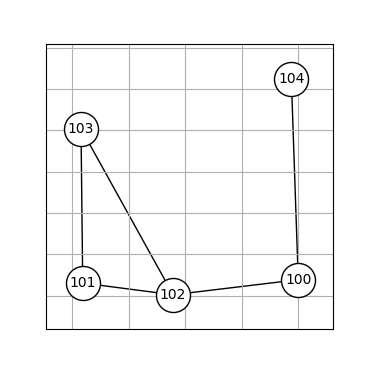

In [36]:
plt.clf()
dec.plot_interaction_graph(graph)
plt.draw()

In [27]:
X0 = torch.tile(x0.T, (N,1))
U0 = torch.zeros((N, n_controls*n_agents))

In [28]:
%%time
X_dec, U_dec, J_dec = dec.solve_decentralized(prob, X0, U0, radius, is_mp=False)

0/50	J: 26379.9
1/50	J: 1868	μ: 0.5	Δ: 0.5
2/50	J: 1864.47	μ: 0.125	Δ: 0.25
Problem 100: [100]
Took 0.7208006999990175 seconds
0/50	J: 11356
1/50	J: 832.618	μ: 0.5	Δ: 0.5
2/50	J: 803.053	μ: 0.125	Δ: 0.25
Problem 101: [101]
Took 0.6880504000000656 seconds
0/50	J: 5961.45
1/50	J: 1192.64	μ: 0.5	Δ: 0.5
2/50	J: 440.511	μ: 0.125	Δ: 0.25
3/50	J: 433.58	μ: 0.015625	Δ: 0.125
4/50	J: 432.923	μ: 0.000976562	Δ: 0.0625
Problem 102: [102]
Took 1.1082776999992348 seconds
0/50	J: 14061
1/50	J: 4776.3	μ: 0.5	Δ: 0.5
2/50	J: 1114.57	μ: 0.125	Δ: 0.25
3/50	J: 1069.2	μ: 0.015625	Δ: 0.125
4/50	J: 1034.89	μ: 0.000976562	Δ: 0.0625
5/50	J: 1028.54	μ: 3.05176e-05	Δ: 0.03125
6/50	J: 1025.82	μ: 0	Δ: 0.015625
7/50	J: 1024.56	μ: 0	Δ: 0.0078125
Problem 103: [103]
Took 2.0048832000011316 seconds
0/50	J: 3742.75
1/50	J: 518.531	μ: 0.5	Δ: 0.5
2/50	J: 271.294	μ: 0.125	Δ: 0.25
3/50	J: 270.03	μ: 0.015625	Δ: 0.125
Problem 104: [104]
Took 0.9447392000001855 seconds
CPU times: user 5.5 s, sys: 48.5 ms, total: 5.55 s
Wall tim

In [78]:
plt.clf()
plot_solve(X_dec, J_dec, x_goal.numpy(), x_dims)

In [29]:
X = X_dec.clone()

## decentralized multi-agent receding horizon
Adding RHC to the decentralized implementation would just be a matter of indexing a subset of the generated states in the combined decentralized solutions.

## animation

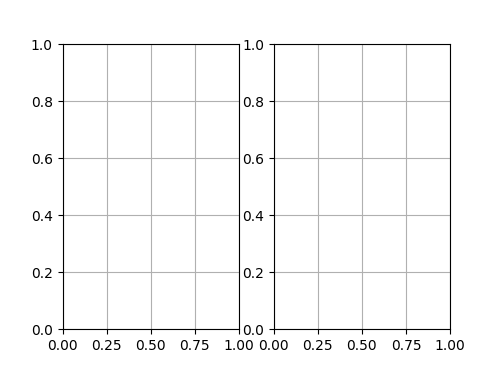

In [52]:
_, axes = plt.subplots(1, 2, figsize=(5.0, 3.7))

In [50]:
def setup(axes, X, x_goal, x_dims, radius):
    
    ax1, ax2 = axes
    n_agents = len(x_dims)
    handles1 = []
    for i in range(n_agents):
        handles1.append((
            ax1.plot(0, c=plt.cm.tab20.colors[2*i], marker='o', markersize=4)[0],
            ax1.add_artist(plt.Circle(np.nan, radius, color='k', fill=True, alpha=0.3, lw=2)),
        ))
        
    for xg in split_agents(x_goal, x_dims):
        ax1.scatter(xg[0,0], xg[0,1], c='r', marker='x', zorder=10)

    X_cat = np.vstack(split_agents(X, x_dims))
    pocketknives.set_bounds(X_cat, axes[0], zoom=0.15)
    plt.draw()
    
    handles2 = []
    n_pairs = pocketknives.nchoosek(n_agents, 2)
    for i in range(n_pairs):
        handles2.append(ax2.plot(0, c=plt.cm.tab20.colors[2*i])[0])
    ax2.hlines(radius, 0, X.shape[0], 'r', ls='--')
    ax2.set_ylim(0.0, distances.max())
        
    return handles1, handles2
    
def animate(t, handles1, handles2, X, x_dims, x_goal, distances):
    """Animate the solution into a gif"""
    
    for (i, xi), hi in zip(enumerate(split_agents(X, x_dims)), handles1):
        hi[0].set_xdata(xi[:t,0])
        hi[0].set_ydata(xi[:t,1])
        hi[1].set_center(xi[t-1,:2])
        
    for i, hi in enumerate(handles2):
        hi.set_xdata(range(t))
        hi.set_ydata(distances[:t, i])
    
    plt.draw()
    

In [51]:
distances = dec.compute_pairwise_distance(X, x_dims).T
handles1, handles2 = setup(axes, X, x_goal.flatten(), x_dims, radius)
animate(10, handles1, handles2, X, x_dims, x_goal, distances)
plt.draw()

In [53]:
handles = setup(axes, X, x_goal.flatten(), x_dims, radius)
anim = FuncAnimation(
    plt.gcf(), 
    animate, 
    frames=N+1, 
    fargs=(*handles, X, x_dims, x_goal, distances))
anim.save('traj.gif', fps=5)

MovieWriter ffmpeg unavailable; using Pillow instead.
